### Source
source: https://github.com/wiseodd/generative-models/tree/master/GAN/vanilla_gan

### Summary
Try Fitting Gaussian Mixed Model

### To be Done
1. Add epoch title 
2. Track loss function evolution
3. legend sharp red

### Brian-storm


In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import math
from sklearn import mixture
%matplotlib inline

In [2]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

### Parameters

In [19]:
epoch_n = 31000
dt_steps = 5
dg_steps = 1
mb_size = 256
X_dim = 2
z_dim = 2
h_dim = 16

### Data Steps


In [5]:
def generate_GMM(n):
    C = np.array([[0., -0.7], [3.5, .7]])
    g1 = np.random.randn(n, 2) + np.array([20, 20])
    g2 = np.random.randn(n, 2) + np.array([0, 10])
    g3 = np.dot(np.random.randn(n, 2), C)
    combine_g = np.vstack([g1, g2, g3])
    return combine_g

def sample_GMM(gen_GMM, n_samples):
    n_row = gen_GMM.shape[0]
    idx = np.random.randint(n_row, size = n_samples)
    return gen_GMM[idx, :]

# generate prior noise
def sample_z(m, n):
    return np.random.uniform(-1., 1., size = [m, n])

In [6]:
GMM_pop = generate_GMM(2000)

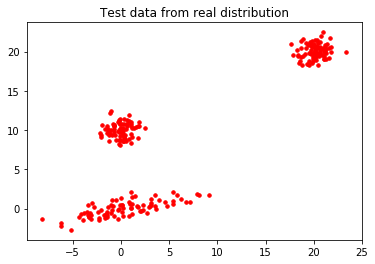

In [7]:
test_data = sample_GMM(GMM_pop, mb_size)
plt.scatter(test_data[:, 0], test_data[:, 1], c = 'r', s = 12)
plt.title('Test data from real distribution');

### Weight

In [8]:
X = tf.placeholder(tf.float32, shape=[None, X_dim])

D_W1 = tf.Variable(xavier_init([X_dim, h_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
D_b2 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W3 = tf.Variable(xavier_init([h_dim, h_dim]))
D_b3 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W4 = tf.Variable(xavier_init([h_dim, h_dim]))
D_b4 = tf.Variable(tf.zeros(shape=[h_dim]))
D_W5 = tf.Variable(xavier_init([h_dim, 1]))
D_b5 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_W3, D_W4, D_W5, D_b1, D_b2, D_b3, D_b4, D_b5]


Z = tf.placeholder(tf.float32, shape=[None, z_dim])

G_W1 = tf.Variable(xavier_init([z_dim, h_dim]))
G_b1 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W2 = tf.Variable(xavier_init([h_dim, h_dim]))
G_b2 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W3 = tf.Variable(xavier_init([h_dim, h_dim]))
G_b3 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W4 = tf.Variable(xavier_init([h_dim, h_dim]))
G_b4 = tf.Variable(tf.zeros(shape=[h_dim]))
G_W5 = tf.Variable(xavier_init([h_dim, X_dim]))
G_b5 = tf.Variable(tf.zeros(shape=[X_dim]))

theta_G = [G_W1, G_W2, G_W3, G_W4, G_W5, G_b1, G_b2, G_b3, G_b4, G_b5]

### Model Architecture

In [9]:
def generator(z):
    G_h1 = tf.nn.leaky_relu(tf.matmul(z, G_W1) + G_b1)
    G_h2 = tf.nn.leaky_relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_h3 = tf.nn.leaky_relu(tf.matmul(G_h2, G_W3) + G_b3)
    G_h4 = tf.nn.leaky_relu(tf.matmul(G_h3, G_W4) + G_b4)
    output = tf.matmul(G_h4, G_W5) + G_b5
    #G_prob = tf.nn.sigmoid(G_log_prob) # curse of mode collapse
    return output

def discriminator(x):
    D_h1 = tf.nn.leaky_relu(tf.matmul(x, D_W1) + D_b1)
    D_h2 = tf.nn.leaky_relu(tf.matmul(D_h1, D_W2) + D_b2)
    D_h3 = tf.nn.leaky_relu(tf.matmul(D_h2, D_W3) + D_b3)
    D_h4 = tf.nn.leaky_relu(tf.matmul(D_h3, D_W4) + D_b4)
    D_logit = tf.matmul(D_h4, D_W5) + D_b5
    D_prob = tf.nn.sigmoid(D_logit)
    #D_prob = D_logit
    return D_prob, D_logit

In [10]:
G_sample = generator(Z)
D_real, D_logit_real = discriminator(X)
D_fake, D_logit_fake = discriminator(G_sample)

In [11]:
# alternative loss function
#D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
#D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
#D_loss = D_loss_real + D_loss_fake
#G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

# original paper
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake))

D_solver = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(G_loss, var_list=theta_G)

### Training

In [12]:
fix_r_samples = generate_GMM(1000)
data_path = 'data_iter_gan/data_%d.png'
loss_path = 'loss_iter_gan/loss_%d.png'

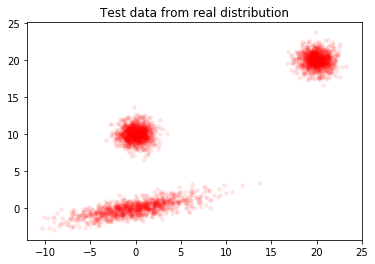

In [13]:
plt.scatter(fix_r_samples[:, 0], fix_r_samples[:, 1], c = 'r', s = 12, alpha = 0.08)
plt.title('Test data from real distribution');

Iterations: 0	 Discriminator loss: 1.1236	 Generator loss: 0.5121
Iterations: 1000	 Discriminator loss: 0.6620	 Generator loss: 1.6103
Iterations: 2000	 Discriminator loss: 0.6662	 Generator loss: 1.5546
Iterations: 3000	 Discriminator loss: 0.7297	 Generator loss: 1.4693
Iterations: 4000	 Discriminator loss: 0.7286	 Generator loss: 1.4610
Iterations: 5000	 Discriminator loss: 0.7274	 Generator loss: 1.4105
Iterations: 6000	 Discriminator loss: 0.7864	 Generator loss: 1.4159
Iterations: 7000	 Discriminator loss: 0.7588	 Generator loss: 1.3297
Iterations: 8000	 Discriminator loss: 0.7876	 Generator loss: 1.3482
Iterations: 9000	 Discriminator loss: 0.7790	 Generator loss: 1.4495
Iterations: 10000	 Discriminator loss: 0.7946	 Generator loss: 1.3866
Iterations: 11000	 Discriminator loss: 0.7114	 Generator loss: 1.3898
Iterations: 12000	 Discriminator loss: 0.7206	 Generator loss: 1.3824
Iterations: 13000	 Discriminator loss: 0.7566	 Generator loss: 1.3730
Iterations: 14000	 Discriminator 

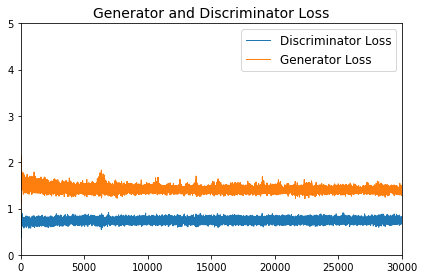

In [22]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
d_loss_list = []
g_loss_list = []

for it in range(epoch_n):
    # discriminator steps
    for _ in range(dt_steps):
        X_batch = sample_GMM(GMM_pop, mb_size)
        Z_batch = sample_z(mb_size, 2)
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_batch, Z: Z_batch})
    d_loss_list.append(D_loss_curr)
    # generator step
    for _ in range(dg_steps):
        Z_batch = sample_z(mb_size, 2)
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={Z: Z_batch})
    g_loss_list.append(G_loss_curr)
        
    if it % 1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(it, D_loss_curr, G_loss_curr))
        
        # generate data plot
        data_f_out = data_path%it
        vis_data_evolution(fix_r_samples, it, data_f_out)
        # generate loss plot
        loss_f_out = loss_path%it
        vis_loss_evolution(d_loss_list, g_loss_list, epoch_n - 1000, loss_f_out)

print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(it, D_loss_curr, G_loss_curr))
sess.close()

### Visualization for Data

In [105]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [15]:
def vis_data_evolution(r_samples, iter_n, f_out, dpi = 400):
    plt.clf()
    # prepare data
    z_samples = sample_z(mb_size, 2)
    g_samples = sess.run(G_sample, feed_dict = {Z: z_samples})
    # start scatter plot
    gen = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 14, alpha = 0.6)
    real = plt.scatter(x = r_samples[:, 0], y = r_samples[:, 1], c = 'r', s = 14, alpha = 0.08)
    # fix legend
    plt.legend((gen, real), ('Generated Data', 'Real Data'), prop = {'size': 12}, loc = 2)
    ax = plt.gca()
    leg = ax.get_legend()
    leg.legendHandles[0].set_alpha(1)
    leg.legendHandles[1].set_alpha(1)
    # fix axis
    plt.ylim((-5, 25))
    plt.xlim((-10, 25))
    # setup title
    title_str = '%05d Epoch'%iter_n
    plt.title(title_str, fontdict = {'size': 14})
    plt.subplots_adjust(top = 0.8)
    # with high resolution
    plt.tight_layout()
    plt.savefig(f_out, dpi = dpi)

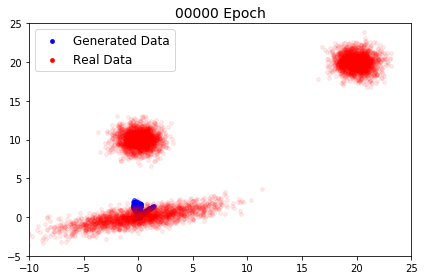

In [131]:
vis_data_evolution(GMM_pop, iter_n = 0, f_out = 'data_iter_gan/testing.png', dpi = 400)

### Visualization for Loss Curve

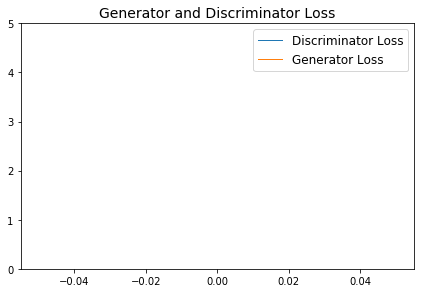

In [16]:
m = len(d_loss_list)
d = plt.plot(range(m), d_loss_list, linewidth = 1, label = 'Discriminator Loss')
g = plt.plot(range(m), g_loss_list, linewidth = 1, label = 'Generator Loss')
plt.legend(loc = 1, prop = {'size': 12})
plt.ylim((0, 5))
plt.tight_layout()
plt.title('Generator and Discriminator Loss', fontdict = {'size': 14});

In [17]:
def vis_loss_evolution(d_loss_list, g_loss_list, epoch_n, f_out, dpi = 400):
    plt.clf()
    # plot line
    m = len(d_loss_list)
    d = plt.plot(range(m), d_loss_list, linewidth = 1, label = 'Discriminator Loss')
    g = plt.plot(range(m), g_loss_list, linewidth = 1, label = 'Generator Loss')
    plt.legend(loc = 1, prop = {'size': 12})
    plt.ylim((0, 5))
    plt.xlim((0, epoch_n))
    plt.tight_layout()
    plt.title('Generator and Discriminator Loss', fontdict = {'size': 14})
    plt.subplots_adjust(top = 0.9)
    plt.savefig(f_out, dpi = dpi);

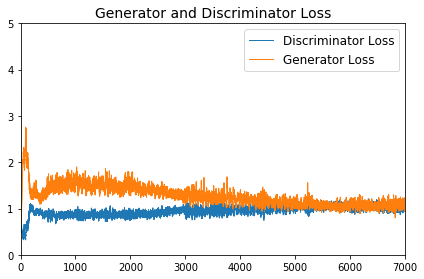

In [136]:
vis_loss_evolution(d_loss_list, g_loss_list, epoch_n - 1000, 'loss_iter_gan/testing.png')

### Visualization

In [18]:
z_samples = sample_z(mb_size, 2)
g_samples = sess.run(G_sample, feed_dict={Z: z_samples})
r_samples = sample_GMM(GMM_pop, mb_size)

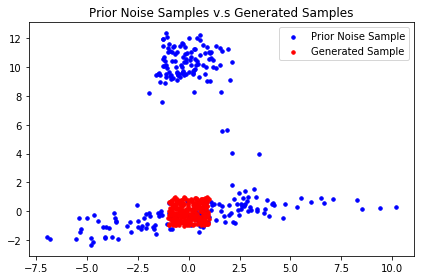

In [19]:
noise = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
transform = plt.scatter(x = z_samples[:, 0], y = z_samples[:, 1], c = 'r', s = 12)
plt.legend((noise, transform), ('Prior Noise Sample', 'Generated Sample'))
plt.title('Prior Noise Samples v.s Generated Samples');
plt.tight_layout();

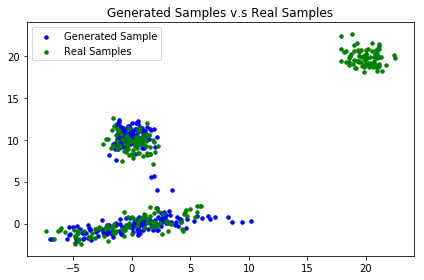

In [20]:
transform = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
real = plt.scatter(r_samples[:, 0], r_samples[:, 1], c = 'g', s = 12)
plt.legend((transform, real), ('Generated Sample', 'Real Samples'))
#plt.ylim((0, 100))
plt.title('Generated Samples v.s Real Samples')
plt.tight_layout();

- Mope Collapse occurs!!

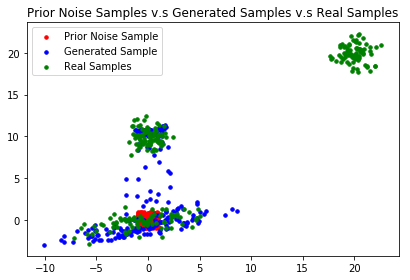

In [16]:
noise = plt.scatter(x = z_samples[:, 0], y = z_samples[:, 1], c = 'r', s = 12)
transform = plt.scatter(x = g_samples[:, 0], y = g_samples[:, 1], c = 'b', s = 12)
real = plt.scatter(r_samples[:, 0], r_samples[:, 1], c = 'g', s = 12)
plt.legend((noise, transform, real), ('Prior Noise Sample', 'Generated Sample', 'Real Samples'))
#plt.ylim((0, 100))
plt.title('Prior Noise Samples v.s Generated Samples v.s Real Samples')
plt.tight_layout();

### Weight Distributions

In [17]:
def get_weights(param1, param2):
    param1_arr = np.array([])
    param2_arr = np.array([])
    for t_var in param1:
        tmp = sess.run(t_var).ravel().copy()
        param1_arr = np.hstack([tmp, param1_arr])
    for t_var in param2:
        tmp = sess.run(t_var).ravel().copy()
        param2_arr = np.hstack([tmp, param2_arr])
    return param1_arr, param2_arr

In [18]:
theta_D_arr, theta_G_arr = get_weights(theta_D, theta_G)

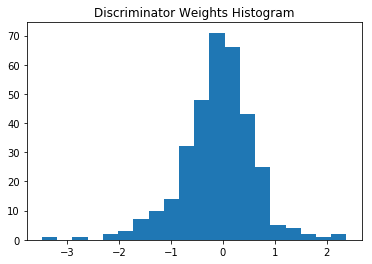

In [19]:
plt.hist(theta_D_arr, bins = 20)
plt.title('Discriminator Weights Histogram');

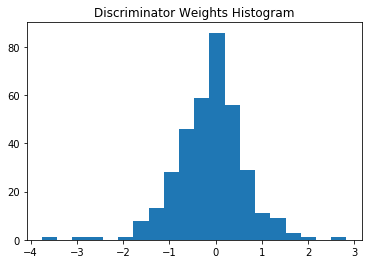

In [20]:
plt.hist(theta_G_arr, bins = 20)
plt.title('Discriminator Weights Histogram');